In [108]:
from nba_api.stats.endpoints import leaguegamefinder, playercareerstats
from nba_api.stats.static import players
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

Test pour Nikola Jokić (player_id = '203999')

In [109]:
NikoJokic = playercareerstats.PlayerCareerStats(player_id='203999')
jokic_df = NikoJokic.get_data_frames()[0]
print(jokic_df)

    PLAYER_ID SEASON_ID LEAGUE_ID     TEAM_ID TEAM_ABBREVIATION  PLAYER_AGE  \
0      203999   2015-16        00  1610612743               DEN        21.0   
1      203999   2016-17        00  1610612743               DEN        22.0   
2      203999   2017-18        00  1610612743               DEN        23.0   
3      203999   2018-19        00  1610612743               DEN        24.0   
4      203999   2019-20        00  1610612743               DEN        25.0   
5      203999   2020-21        00  1610612743               DEN        26.0   
6      203999   2021-22        00  1610612743               DEN        27.0   
7      203999   2022-23        00  1610612743               DEN        28.0   
8      203999   2023-24        00  1610612743               DEN        29.0   
9      203999   2024-25        00  1610612743               DEN        30.0   
10     203999   2025-26        00  1610612743               DEN        30.0   

    GP  GS   MIN  FGM  ...  FT_PCT  OREB  DREB   RE

Liste de tous les joueurs NBA sous forme de liste avec nom/prénom/full nom/id/is_active
On Récupère tous les joueurs NBA (actifs + historiques)

In [110]:
nba_players = players.get_players()

On transforme le csv des salaires des joueurs et du salary cap en DataFrame pandas

In [111]:
sal_df = pd.read_csv('data/Salaries.csv', delimiter=';') 
sal_df['Season'] = sal_df['Season'].apply(lambda x: f"{x-1}-{str(x)[-2:]}")
print(sal_df[sal_df["Season"] == "2024-25"].head(20))


cap_df = pd.read_csv('data/salary_cap.csv', delimiter=';')
print("\n", cap_df)

                      Player    Salary   Season
11869          Stephen Curry  55761216  2024-25
11870            Joel Embiid  51415938  2024-25
11871           Nikola Jokic  51415938  2024-25
11872           Kevin Durant  51179021  2024-25
11873           Bradley Beal  50203930  2024-25
11874           Jaylen Brown  49205800  2024-25
11875           Devin Booker  49205800  2024-25
11876     Karl-Anthony Towns  49205800  2024-25
11877            Paul George  49205800  2024-25
11878          Kawhi Leonard  49205800  2024-25
11879           Jimmy Butler  48798677  2024-25
11880  Giannis Antetokounmpo  48787676  2024-25
11881         Damian Lillard  48787676  2024-25
11882           LeBron James  48728845  2024-25
11883            Zach LaVine  44531940  2024-25
11884            Rudy Gobert  43827586  2024-25
11885          Anthony Davis  43219440  2024-25
11886            Luka Doncic  43031940  2024-25
11887             Trae Young  43031940  2024-25
11888          Fred VanVleet  42846615  

On fait la jointure sur la colonne 'Saison'

In [112]:
sal_cap_df = sal_df.merge(cap_df, on='Season', how='left')
sal_cap_df = sal_cap_df[sal_cap_df["Season"] != "1999-00"]
sal_cap_df["ratio_cap"] = sal_cap_df["Salary"] / sal_cap_df["SalaryCapUSD"]
sal_cap_df = sal_cap_df.rename(columns={"Season": "SEASON_ID"})
sal_cap_df["Season"] = sal_cap_df["SEASON_ID"].astype(str)
print(sal_cap_df[sal_cap_df["Season"] == "2024-25"].head(20))
#print(sal_cap_df["Season"].dtype)

                      Player    Salary SEASON_ID  SalaryCapUSD  ratio_cap  \
11869          Stephen Curry  55761216   2024-25   140588000.0   0.396629   
11870            Joel Embiid  51415938   2024-25   140588000.0   0.365721   
11871           Nikola Jokic  51415938   2024-25   140588000.0   0.365721   
11872           Kevin Durant  51179021   2024-25   140588000.0   0.364035   
11873           Bradley Beal  50203930   2024-25   140588000.0   0.357100   
11874           Jaylen Brown  49205800   2024-25   140588000.0   0.350000   
11875           Devin Booker  49205800   2024-25   140588000.0   0.350000   
11876     Karl-Anthony Towns  49205800   2024-25   140588000.0   0.350000   
11877            Paul George  49205800   2024-25   140588000.0   0.350000   
11878          Kawhi Leonard  49205800   2024-25   140588000.0   0.350000   
11879           Jimmy Butler  48798677   2024-25   140588000.0   0.347104   
11880  Giannis Antetokounmpo  48787676   2024-25   140588000.0   0.347026   

On a les 25 csv avec les stats des joueurs. On les mets en df et on les travaille 

In [113]:
for i in range(25):
    if i < 10:
        var_name = f"stats_df_0{i}"
    else:
        var_name = f"stats_df_{i}"
    globals()[var_name] = pd.read_csv(f'data/nba_players{i}.csv')
    globals()[var_name].drop(columns=['Player.1'], inplace=True) #Il y a une deuxième colonne nom qui apparaît, je ne sais pas pourquoi. Je peux donc la drop
    globals()[var_name] = globals()[var_name][globals()[var_name]['SEASON_ID'] != '2025-26'] #On drop la saison 2025-26 dans chaque df parce qu'elle est incomplète
    list_drop = []
    mask = (~globals()[var_name].duplicated(subset=['Player', 'SEASON_ID'], keep=False)| (globals()[var_name]['TEAM_ABBREVIATION'] == 'TOT'))
    globals()[var_name] = globals()[var_name][mask].reset_index(drop=True)
    globals()[var_name] = globals()[var_name].sort_values(['Player','SEASON_ID']).reset_index(drop=True)
    for j in range(len(globals()[var_name]) - 1):
        if globals()[var_name]['GP'][j] < 30 :
            list_drop.append(j)
    globals()[var_name].drop(index=list_drop).reset_index(drop=True)   
    if 'Unnamed: 0' in globals()[var_name].columns:
        globals()[var_name].drop(columns=['Unnamed: 0'], inplace=True) #On drop la colonne Unnamed: 0 qui apparaît à la lecture du csv
        

print(stats_df_09.columns)
print(stats_df_09.head(20))

Index(['Player', 'SEASON_ID', 'PPG', 'RPG', 'APG', 'BPG', 'SPG',
       'TEAM_ABBREVIATION', 'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FG_PCT',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'TOVPG', 'PFPG', 'FG3MPG', 'FG3APG',
       'FGMPG', 'FGAPG', 'OREBPG'],
      dtype='object')
             Player SEASON_ID    PPG   RPG   APG   BPG   SPG  \
0        AJ Hammons   2016-17   2.18  1.64  0.18  0.59  0.05   
1    Aaron Harrison   2015-16   0.86  0.71  0.10  0.00  0.29   
2    Aaron Harrison   2016-17   0.20  0.60  0.60  0.00  0.00   
3    Aaron Harrison   2017-18   6.67  2.67  1.22  0.22  1.00   
4   Adam Harrington   2002-03   1.58  0.42  0.63  0.05  0.11   
5   Andrew Harrison   2016-17   5.90  1.89  2.75  0.29  0.74   
6   Andrew Harrison   2017-18   9.52  2.34  3.16  0.46  0.68   
7   Andrew Harrison   2018-19   3.18  1.18  1.41  0.12  0.24   
8    Ben Handlogten   2003-04   4.00  3.24  0.35  0.24  0.18   
9    Ben Handlogten   2004-05   4.52  3.10  0.62  0.24  0.33   
10   Ben Hansbrough   2

On vérifie la présence de valeurs manquantes dans le df. On compte le nombre de zéros dans chaque colonne numérique. Des zéros en PPG, RPG, APG, GP, FG_PCT, FTA, FTM, PFPG montrent que le joueur n'a pas (ou à peine) joué. On ne peut pas l'inclure dans le modèle car ces zéros représentent un manque flagrant d'absence de données sur le joueur.
 

In [114]:
for i in range(25):
    if i < 10 : 
        var_name = f"stats_df_0{i}"
    else:
        var_name = f"stats_df_{i}"
    #print(globals()[var_name].isna().sum())
    #print(globals()[var_name][globals()[var_name].isna().any(axis=1)])

    #On compte le nombre de zéros dans chaque colonne numérique. Des zéros en PPG, RPG, APG, GP, FG_PCT, FTA, FTM, PFPG montrent que le joueur n'a pas ou à peine joué. On ne peut pas l'inclure dans le modèle car ces zéros représentent un manque flagrant d'absence de données sur le joueur
    colonnes_critiques = ["PPG", "RPG", "APG", "GP", "FG_PCT", "FTA", "FTM", "PFPG"]
    globals()[var_name] = globals()[var_name][~(globals()[var_name][colonnes_critiques] == 0).any(axis=1)] #On enlève les lignes qui contiennt un 0 parmi une des "stats critiques"
    #for col in colonnes_critiques:
        #if globals()[var_name][col].dtype in ['float64', 'int64']:
            #print(f"{col}: { (globals()[var_name][col] == 0).sum() } zéros")
            

On fusionne les 25 df des stats des joueurs en un seul df

In [115]:
liste_stats_df = [globals()[f"stats_df_0{i}"] for i in range(10)]+[globals()[f"stats_df_{i}"] for i in range(10, 25)]
stats_all_df = pd.concat(liste_stats_df, ignore_index=True)
print(f"On a {len(stats_all_df)} saisons de joueurs après nettoyage dans le dataset")  
#Résultat : pas de valeurs manquantes

On a 9402 saisons de joueurs après nettoyage dans le dataset


On fusionne les deux dataframes que l'on avait avant pour ne travailler qu'avec la fusion (full_df)

In [116]:
# Merge X et Y

full_df = stats_all_df.merge(sal_cap_df[["Player","SEASON_ID","ratio_cap"]], on=["Player","SEASON_ID"], how='inner')
print(full_df.head(20))


             Player SEASON_ID    PPG   RPG   APG   BPG   SPG  \
0   Al-Farouq Aminu   2010-11   5.64  3.30  0.74  0.31  0.73   
1   Al-Farouq Aminu   2011-12   6.05  4.67  1.00  0.52  0.89   
2   Al-Farouq Aminu   2012-13   7.30  7.70  1.36  0.67  1.21   
3   Al-Farouq Aminu   2013-14   7.15  6.20  1.42  0.48  1.02   
4   Al-Farouq Aminu   2014-15   5.57  4.62  0.80  0.84  0.95   
5   Al-Farouq Aminu   2015-16  10.23  6.09  1.68  0.65  0.88   
6   Al-Farouq Aminu   2016-17   8.72  7.39  1.62  0.72  0.98   
7   Al-Farouq Aminu   2017-18   9.33  7.61  1.22  0.58  1.14   
8   Al-Farouq Aminu   2018-19   9.38  7.53  1.28  0.41  0.84   
9   Al-Farouq Aminu   2019-20   4.33  4.83  1.17  0.44  1.00   
10  Al-Farouq Aminu   2020-21   4.43  4.78  1.35  0.39  0.83   
11    Alan Anderson   2005-06   5.75  1.94  0.89  0.11  0.31   
12    Alan Anderson   2006-07   5.76  1.88  1.24  0.00  0.41   
13    Alan Anderson   2011-12   9.59  2.00  1.53  0.18  0.29   
14    Alan Anderson   2012-13  10.66  2.

Etude statistique du df : statistiques descriptives et intervalle de confiance 95%

In [117]:
y = full_df['ratio_cap']

# Statistiques descriptives de base
print(y.describe())  # count, mean, std, min, quartiles, max [web:547][web:543]

# Intervalle de confiance à 95 % pour la moyenne de y
mean = y.mean()
std = y.std(ddof=1)
n = y.count()
se = std / np.sqrt(n)
z = 1.96  # pour 95%
ci_low = mean - z * se
ci_high = mean + z * se
print(f"IC 95 % pour la moyenne de ratio_cap : [{ci_low:.4f}, {ci_high:.4f}]")

count    8145.000000
mean        0.070020
std         0.078220
min         0.000047
25%         0.015591
50%         0.038618
75%         0.092664
max         0.480223
Name: ratio_cap, dtype: float64
IC 95 % pour la moyenne de ratio_cap : [0.0683, 0.0717]


Corrélation

In [118]:
for elt in full_df.columns : 
    if elt not in ['Player', 'SEASON_ID', 'TEAM_ABBREVIATION', 'ratio_cap']:
        print(full_df[['ratio_cap',elt]].corr())

           ratio_cap       PPG
ratio_cap   1.000000  0.657628
PPG         0.657628  1.000000
           ratio_cap       RPG
ratio_cap   1.000000  0.488216
RPG         0.488216  1.000000
           ratio_cap       APG
ratio_cap   1.000000  0.493507
APG         0.493507  1.000000
           ratio_cap       BPG
ratio_cap   1.000000  0.281377
BPG         0.281377  1.000000
           ratio_cap      SPG
ratio_cap    1.00000  0.41719
SPG          0.41719  1.00000
            ratio_cap  PLAYER_AGE
ratio_cap     1.00000     0.33229
PLAYER_AGE    0.33229     1.00000
           ratio_cap        GP
ratio_cap   1.000000  0.253556
GP          0.253556  1.000000
           ratio_cap        GS
ratio_cap   1.000000  0.525959
GS          0.525959  1.000000
           ratio_cap       MIN
ratio_cap   1.000000  0.487733
MIN         0.487733  1.000000
           ratio_cap    FG_PCT
ratio_cap   1.000000  0.152599
FG_PCT      0.152599  1.000000
           ratio_cap   FG3_PCT
ratio_cap   1.000000  0.096738
FG

Illustration de la relation entre PPG ratio_cap

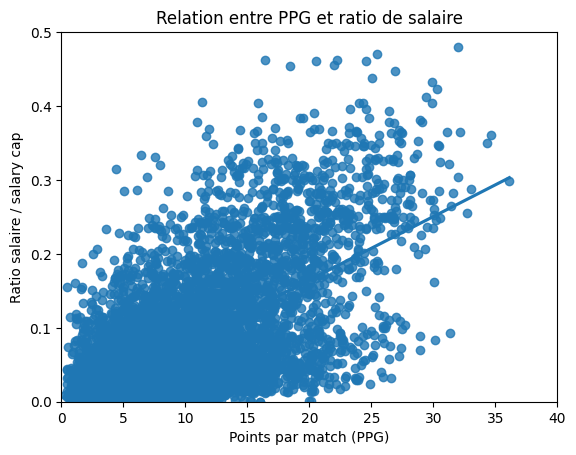

In [119]:
sns.regplot(x='PPG', y='ratio_cap', data=full_df, ci=None)  
plt.xlabel('Points par match (PPG)')
plt.ylabel('Ratio salaire / salary cap')
plt.xlim(0, 40)
plt.ylim(0, 0.5)
plt.title('Relation entre PPG et ratio de salaire')
plt.show()

In [120]:

X = full_df[['PPG']]          
X = sm.add_constant(X)    # On ajoute la constante pour l’intercept
y = full_df['ratio_cap']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              ratio_cap   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     6205.
Date:                Thu, 20 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:27:33   Log-Likelihood:                 11505.
No. Observations:                8145   AIC:                        -2.301e+04
Df Residuals:                    8143   BIC:                        -2.299e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0070      0.001     -5.991      0.0

D'abord on initialise le spliter gss1. On prend 20% de nos données pour le test (et donc 80% pour entraîner et valider le modèle). Le random_state = 42 est une seed qui permet donc de reproduire l'expérience si on le souhaite (ou la changer).
ggs1.split retourne les indices des lignes qui vont en train/validation ou en test. 
test est donc le set de test (on a récupéré test en utilisant les indices contenus dans test_idx). De même avec trainval. 

gss2 sert à faire le split en training et validation. On reprend encore une fois 20% pour la validation. On change la seed à 43. On ne réutilise pas gss1 pour qu'il y ait indépendance totale des processus de sélection des sets de données.
On récupère train et val de la même manière que l'on a pris test et trainval précédement. 

In [121]:
groups = full_df['Player']

gss1 = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42) # Test set (20%)
trainval_idx, test_idx = next(gss1.split(full_df, full_df['ratio_cap'], groups))
trainval = full_df.iloc[trainval_idx].reset_index(drop=True)
test = full_df.iloc[test_idx].reset_index(drop=True)

gss2 = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=43) # Validation set (16% tot)
train_idx, val_idx = next(gss2.split(trainval, trainval['ratio_cap'], trainval['Player']))
train = trainval.iloc[train_idx].reset_index(drop=True)
val = trainval.iloc[val_idx].reset_index(drop=True)

Ici on utilise des pipelines. les pipelines servent à chaîner le pré-traitement et l'utilisation du modèle de manière concise et "automatique" (On peut les réutiliser ce qui est pratique pour accélérer et uniformiser le travail.
num_proc sert à traiter les colonnes numériques. SimpleImputer sert à insérer la médiane dans des colonnes où des valeurs manquent. Scaler permet "d'uniformiser" les valeurs en ayant une moyenne à 0 (ou 1 je sais plus) et 1 d'écart-type. Cela aide pour les calculs.

Le dernier pipeline contient ridge comme modèle. Ridge est le modèle que nous utilisons. Il s'agit d'une régression multi-linéaire avec une régularisation de termes au carré. C'est une régression multi-linéaire avec une fonction de coût de la forme (somme des lambda alpha^2) qui sera minimisée. Cela nous est très utile dans notre cas car il y a énormément de statistiques en NBA et il fait donc sens de les inclure comme paramètres de notre modèle. Cependant, il risque fatalement de s'avérer que plusieurs de ces statistiques n'ont pas une grande importance dans le modèle final. Le ridge permet de minimiser les paramètres qui ont un minimum d'importance. Il existe aussi un modèle qui permet d'annuler l'importance de certains paramètres (Lasso). Nous préférons utiliser le ridge qui minimise sans annuler. 

In [122]:
# Définir les features (exclut Player, SEASON_ID, ratio_cap)
features = [c for c in train.columns if c not in ['Player', 'SEASON_ID', 'ratio_cap']]
num_cols = train[features].select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in features if c not in num_cols]

num_proc = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_proc = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preproc = ColumnTransformer([
    ('num', num_proc, num_cols),
    ('cat', cat_proc, cat_cols)
])

ridge = Ridge(alpha=1.0) 
pipe = Pipeline([
    ('preproc', preproc),
    ('model', ridge)
])

On initialise un GroupKFold avec 5 sous-ensembles. ON utilise la méthode GroupKFold plutôt qu'un KFold calssique puisque former des groupes est pertinents dans notre cas. Ne pas faire des groupes contenant à chaque fois toutes les saisons d'un même joueur causerait une "fuite de données" (data leakage) entre train set et test set. Prenons l'exemple de Lebron James. Toutes ses saisons (toutes les lignes contenant "Lebron James" dans la colonne Player) seront soit en test set soit dans le train set (et dans le même sous-ensemble, ce qui fait qu'on ne peut pas avoir Lebron James et dans le train set et dans le validation set). Le seul inconvénient est que l'on a un processus moins randomisé que le Kfold qui en forme aucun group. On aura une variance un peu plus élevé mais on évite tout data leakage et on donne du sens à chaque set. 

Ensuite, groups_train indique dans quel ensemble sont chaque joueur. 

alphas est un dictionnaire qui représente la grille d'hyperparamètre pour GridSearchCV. les valeurs de alpha sont les paramètres de régularisation du ridge. 

GridSearchCV prend en arguments alphas, la méthode d'évaluation (moyenne de l'erreur en valeur absolue) et les features/labels du group d'entraînement oragnisé avec gfk. L'objectif est de tester le modèle avec tous les hyperparamètres alphas différents. Ils sont ensuite évalués selon la méthode d'évaluation. Le alpha qui permet de minimiser le scoring est maintenu. 
A titre d'exemple, si on prenaint la méthode des KNN, GridSearchCV nous permettrait de savoir le nombre optimal de voisins à avoir pour faire la meilleure prédiction possible. 

Enfin, on fit notre modèle avec les features et les labels. 

In [123]:
gkf = GroupKFold(n_splits=5)
groups_train = train['Player']

# GridSearch pour ajuster alpha (régularisation) sur le train set
alphas = {'model__alpha': [0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(pipe, param_grid=alphas, scoring='neg_mean_absolute_error', cv=gkf.split(train[features], train['ratio_cap'], groups_train))
gs.fit(train[features], train['ratio_cap'])

print("Meilleur alpha:", gs.best_params_)
model_fitted = gs.best_estimator_.named_steps['model']  # extrait l'objet Ridge
pipe = gs.best_estimator_
preproc_fitted = pipe.named_steps['preproc']
model_fitted = pipe.named_steps['model']  # si tu n'utilises pas MultiOutputRegressor


feature_names = preproc_fitted.get_feature_names_out()
for name, coef in zip(feature_names, model_fitted.coef_):
    print(f"{name}: {coef}")
print("Intercept :", model_fitted.intercept_)

print("Score de CV (MAE):", -gs.best_score_)

Meilleur alpha: {'model__alpha': 100}
num__PPG: 0.02100371714742975
num__RPG: 0.020299548522646815
num__APG: 0.007004513656375959
num__BPG: 0.005237525191359017
num__SPG: -0.003935825401178846
num__PLAYER_AGE: 0.02388112561222481
num__GP: -0.0005802060367863011
num__GS: 0.012371084049245747
num__MIN: -0.012958645736167904
num__FG_PCT: -0.0025478353715998165
num__FG3_PCT: -0.004551543666040481
num__FTM: 0.0023182027468926997
num__FTA: 0.0025625310543635174
num__FT_PCT: -0.002820362243155037
num__TOVPG: 0.003258958447104876
num__PFPG: -0.007532293177274757
num__FG3MPG: 0.006403490074027739
num__FG3APG: -0.0035234215637349807
num__FGMPG: 0.013467072415561082
num__FGAPG: 0.0009364366571741807
num__OREBPG: -0.0079344907297875
cat__TEAM_ABBREVIATION_ATL: 0.003356231606364173
cat__TEAM_ABBREVIATION_BKN: -0.000858605209447744
cat__TEAM_ABBREVIATION_BOS: 0.0038021043883828026
cat__TEAM_ABBREVIATION_CHA: -0.0008642926268825674
cat__TEAM_ABBREVIATION_CHH: -0.00024481937803255547
cat__TEAM_ABBREVI

In [124]:
val_preds = gs.predict(val[features])
mae_val = mean_absolute_error(val['ratio_cap'], val_preds)
print(f"MAE validation set : {mae_val:.4f}")
r2 = r2_score(test['ratio_cap'], test_preds)
print("R2 Test Lasso :", r2)

MAE validation set : 0.0359


ValueError: Found input variables with inconsistent numbers of samples: [1728, 2173]

In [ ]:
trainval = pd.concat([train, val]).reset_index(drop=True)
pipe_best = Pipeline([
    ('preproc', preproc),
    ('model', Ridge(alpha=gs.best_params_['model__alpha']))
])
pipe_best.fit(trainval[features], trainval['ratio_cap'])
test_preds = pipe_best.predict(test[features])
mae_test = mean_absolute_error(test['ratio_cap'], test_preds)
print(f"MAE test set : {mae_test:.4f}")
print("MAE Validation:", mean_absolute_error(val['ratio_cap'], val_preds))
print("MAE Test:", mean_absolute_error(test['ratio_cap'], test_preds))
moy = test['ratio_cap'].mean()
err_moy = mean_absolute_error(test['ratio_cap'], test_preds)
print(moy, err_moy)

On obtient une erreur moyenne absolue de 0,0391 sur la prédiction. On est proche de la même erreur entre test set et validation set. On a donc évité l'overfitting. 


Désormais, on se penche sur un deuxième modèle, plus strict : le Lasso. Il s'agit aussi d'une régression mutli-linéaire mais celle-ci peut annuler certains paramètres grâce à la fonction de coût que l'on ajoute à la régression multi-linéaire (l'objectif étant toujours de minimiser cette fonction de coût). 

In [125]:
lasso = Lasso(max_iter=10000) 
pipe_l = Pipeline([
    ('preproc', preproc),
    ('model', lasso)
])
alphas = {'model__alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 3, 5, 10, 30, 100]}
gkf = GroupKFold(n_splits=5)
groups_train = train['Player']

gs = GridSearchCV(pipe_l, param_grid=alphas,
                  scoring='neg_mean_absolute_error',
                  cv=gkf.split(train[features], train['ratio_cap'], groups_train))
gs.fit(train[features], train['ratio_cap'])

print("Meilleur alpha:", gs.best_params_)
print("Score de CV (MAE):", -gs.best_score_)

Meilleur alpha: {'model__alpha': 0.001}
Score de CV (MAE): 0.038031845334646305


In [126]:
lasso_fitted = gs.best_estimator_.named_steps['model']
preproc_fitted = gs.best_estimator_.named_steps['preproc']
feature_names = preproc_fitted.get_feature_names_out()

for name, coef in zip(feature_names, lasso_fitted.coef_):
    print(f"{name}: {coef}")

num__PPG: 0.03760910468629112
num__RPG: 0.012148042025525406
num__APG: 0.005619203477597262
num__BPG: 0.003499499079099397
num__SPG: -0.0016659780417410514
num__PLAYER_AGE: 0.02345393956980032
num__GP: -0.00475079299975563
num__GS: 0.00728905563299768
num__MIN: -0.0
num__FG_PCT: -0.0008706334799295414
num__FG3_PCT: -0.0029814044085913717
num__FTM: 0.0
num__FTA: 0.0
num__FT_PCT: -0.0017072838629356602
num__TOVPG: 0.0021607923518757394
num__PFPG: -0.006176706500629116
num__FG3MPG: 0.0
num__FG3APG: 0.0
num__FGMPG: 0.0
num__FGAPG: 0.0
num__OREBPG: -0.0
cat__TEAM_ABBREVIATION_ATL: 0.0
cat__TEAM_ABBREVIATION_BKN: -0.0
cat__TEAM_ABBREVIATION_BOS: 0.0
cat__TEAM_ABBREVIATION_CHA: -0.0
cat__TEAM_ABBREVIATION_CHH: -0.0
cat__TEAM_ABBREVIATION_CHI: 0.0
cat__TEAM_ABBREVIATION_CLE: -0.0
cat__TEAM_ABBREVIATION_DAL: -0.0
cat__TEAM_ABBREVIATION_DEN: 0.0
cat__TEAM_ABBREVIATION_DET: 0.0
cat__TEAM_ABBREVIATION_GSW: 0.0
cat__TEAM_ABBREVIATION_HOU: -0.0
cat__TEAM_ABBREVIATION_IND: 0.0
cat__TEAM_ABBREVIATION_

On voit qu'il a été intéressant de se pencher sur le lasso après le ridge tant une partie importante des paramètres a été annulée par ce modèle. Avec le lasso, on se détac he de l'équipe d'origine du joueur ainsi que les statistiques relatives au nombre de paniers marqués/tentés. 

On peut trouver une cohérence à ce phénomène. Pour les équipes, elles ont certes chacune des particularités qui font que l'on ppurrait juger important de les compter parmi les paramètres, mais entre 2000 et 2025, chaque équipe (plus ou moins) est passée par différentes phases (en terme de compétitivité au sein de la ligue) avec le besoin de recourir à la totalité du cap salarial (ou plus) pour payer les joueurs ainsi qu'à des phases de basse compétitivité où les équipes n'usent pas forcément de la totalité du cap salarial (dans le but de faire des économies).

Pour les statistiques de tirs tentés et marqués, on peut expliquer leur absence par le fait qu'elles se rapportent de manière plutôt proche à la statistique de points pas match (PPG) qui est la plus coefficientée dans le lasso.  

In [127]:
val_preds = gs.predict(val[features])
test_preds = gs.predict(test[features])
print("MAE Validation:", mean_absolute_error(val['ratio_cap'], val_preds))
print("MAE Test:", mean_absolute_error(test['ratio_cap'], test_preds))
print("MAE Validation:", mean_absolute_error(val['ratio_cap'], val_preds))
print("MAE Test:", mean_absolute_error(test['ratio_cap'], test_preds))
moy = test['ratio_cap'].mean()
err_moy = mean_absolute_error(test['ratio_cap'], test_preds)
print(moy, err_moy)

MAE Validation: 0.03615544728687068
MAE Test: 0.039348701588182024
MAE Validation: 0.03615544728687068
MAE Test: 0.039348701588182024
0.07407815773396603 0.039348701588182024


On a 0,0365 d'erreur moyenne absolue pour le validation set et 0,0397 pour le test set. On a donc pas d'overfitting
Cependant, on voit que le lasso a une plus grande erreur que le ridge (0,0391 contre 0,0397). On serait donc plutôt tenté de prendre le ridge.



Désormais, on veut tester un modèle non-linéaire pour voir s'il performe mieux que nos 2 modèle multi-linéaires. On va utiliser le DecisionTreeRegressor.

In [128]:
tree = DecisionTreeRegressor(random_state=42)
pipe_t = Pipeline([
    ('preproc', preproc),
    ('model', tree)])
param_grid = {'model__max_depth': [3, 5, 7, 10, 15, None]}
gkf = GroupKFold(n_splits=5)
groups_train = train['Player']

gs = GridSearchCV(pipe_t, param_grid=param_grid,
                  cv=gkf.split(train[features], train['ratio_cap'], groups_train),
                  scoring='neg_mean_absolute_error')
gs.fit(train[features], train['ratio_cap'])

print("Meilleur max_depth :", gs.best_params_["model__max_depth"])
print("Score de CV (MAE):", -gs.best_score_)

Meilleur max_depth : 5
Score de CV (MAE): 0.034453502695165394


In [129]:
best_tree = gs.best_estimator_.named_steps['model']
preproc_fitted = gs.best_estimator_.named_steps['preproc']
feature_names = preproc_fitted.get_feature_names_out()

importances = best_tree.feature_importances_
for name, imp in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {imp:.4f}")

num__PPG: 0.4845
num__PLAYER_AGE: 0.2589
num__FGMPG: 0.1487
num__RPG: 0.0342
num__GS: 0.0163
num__TOVPG: 0.0114
num__FGAPG: 0.0076
num__BPG: 0.0068
num__FT_PCT: 0.0061
num__APG: 0.0060
num__FG_PCT: 0.0060
num__FG3MPG: 0.0048
num__OREBPG: 0.0047
num__MIN: 0.0040
num__SPG: 0.0000
num__GP: 0.0000
num__FG3_PCT: 0.0000
num__FTM: 0.0000
num__FTA: 0.0000
num__PFPG: 0.0000
num__FG3APG: 0.0000
cat__TEAM_ABBREVIATION_ATL: 0.0000
cat__TEAM_ABBREVIATION_BKN: 0.0000
cat__TEAM_ABBREVIATION_BOS: 0.0000
cat__TEAM_ABBREVIATION_CHA: 0.0000
cat__TEAM_ABBREVIATION_CHH: 0.0000
cat__TEAM_ABBREVIATION_CHI: 0.0000
cat__TEAM_ABBREVIATION_CLE: 0.0000
cat__TEAM_ABBREVIATION_DAL: 0.0000
cat__TEAM_ABBREVIATION_DEN: 0.0000
cat__TEAM_ABBREVIATION_DET: 0.0000
cat__TEAM_ABBREVIATION_GSW: 0.0000
cat__TEAM_ABBREVIATION_HOU: 0.0000
cat__TEAM_ABBREVIATION_IND: 0.0000
cat__TEAM_ABBREVIATION_LAC: 0.0000
cat__TEAM_ABBREVIATION_LAL: 0.0000
cat__TEAM_ABBREVIATION_MEM: 0.0000
cat__TEAM_ABBREVIATION_MIA: 0.0000
cat__TEAM_ABBREVI

In [130]:
val_preds_tree = gs.predict(val[features])
test_preds_tree = gs.predict(test[features])
print("MAE Validation:", mean_absolute_error(val['ratio_cap'], val_preds_tree))
print("MAE Test:", mean_absolute_error(test['ratio_cap'], test_preds_tree))
r2 = r2_score(test['ratio_cap'], test_preds_tree)
print("R2 Test Tree :", r2)

MAE Validation: 0.03262109216012211
MAE Test: 0.036006441754998265
R2 Test Tree : 0.5768456387064431


On a un meilleur résultat pour le DecisionTreeRegressor. Une erreur moyenne absolue de 0,036 comparée aux 0,0391 et 0,0397 des deux modèles multi-linéaires. 
On peut donc être tentés de choisir ce modèle instinctivement mais il ne faut pas oublier que ce modèle non-linéaire n'a pas "l'explicativité" des deux modèles multi-linéaires. On ne peut pas vraiment dire : "le coefficient PPG est pondéré à une valeur de XXX donc quand le PPG monte de YYY, le salaire monte de ZZZ". 
A noter qu'on a un r2 de 0,58, ce qui peut paraitre mauvais. Cependant, au vu des résultats obtenus par des professionnels (r2 max de 0,63 avec du svm https://towardsdatascience.com/predicting-nba-salaries-with-machine-learning-ed68b6f75566/), on peut estimer que c'est finalement acceptable

On essaie d'utiliser le modèle svr pour voir si on a un meilleur r2

In [131]:
svr = SVR(kernel='rbf')  # kernel RBF par défaut, non linéaire

pipe_svr = Pipeline([
    ('preproc', preproc),
    ('model', svr)
])


In [132]:
param_grid = {
    'model__C': [1, 10],
    'model__epsilon': [0.05, 0.1],
    'model__gamma': ['scale', 'auto']  
}

gkf = GroupKFold(n_splits=5)
groups_train = train['Player']

gs_svr = GridSearchCV(
    pipe_svr,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=gkf.split(train[features], train['ratio_cap'], groups_train),
    n_jobs=-1
)

gs_svr.fit(train[features], train['ratio_cap'])

print("Meilleurs hyperparamètres SVR :", gs_svr.best_params_)
print("MAE CV (moyen) :", -gs_svr.best_score_)

Meilleurs hyperparamètres SVR : {'model__C': 1, 'model__epsilon': 0.05, 'model__gamma': 'auto'}
MAE CV (moyen) : 0.03725654776469243


In [133]:
y_val_pred = gs_svr.predict(val[features])
mae_val = mean_absolute_error(val['ratio_cap'], val_preds)
print("MAE validation SVR :", mae_val)

# Test
y_test_pred_svr = gs_svr.predict(test[features])
mae_test = mean_absolute_error(test['ratio_cap'], y_test_pred_svr)
from sklearn.metrics import r2_score
r2_test = r2_score(test['ratio_cap'], y_test_pred_svr)
print("MAE test SVR :", mae_test)
print("R2 test SVR  :", r2_test)

MAE validation SVR : 0.03615544728687068
MAE test SVR : 0.03795717904917045
R2 test SVR  : 0.6058392120441597
